<a href="https://colab.research.google.com/github/gfxluffy/Hyperparameter-Tuning-with-Keras-Tuner/blob/main/Hyperparameter_Tuning_with_Keras_Tuner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hyperparameter Tuning with Keras Tuner

## Installing Keras Tuner and Downloading the Dataset

In [ ]:
!pip install keras-tuner==1.0.1

     |████████████████████████████████| 54 kB 2.2 MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-py3-none-any.whl size=73199 sha256=2b1ddd1c38fc1f04a69e40541892f6c4cfd5412d60bc4de2bcee015bf55b1cf1
  Stored in directory: /root/.cache/pip/wheels/0b/cf/2f/1a1749d3a3650fac3305a8d7f9237b6de7c41068e2f8520ca2
Successfully built keras-tuner
  Attempting uninstall: keras-tuner
    Found existing installation: keras-tuner 1.1.0
    Uninstalling keras-tuner-1.1.0:
      Successfully uninstalled keras-tuner-1.1.0


In [ ]:
!pip install tensorflow==2.3.0

     |████████████████████████████████| 320.4 MB 53 kB/s 
     |████████████████████████████████| 20.1 MB 1.3 MB/s 
     |████████████████████████████████| 459 kB 79.4 MB/s 
     |████████████████████████████████| 2.9 MB 51.5 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.0
    Uninstalling tensorflow-2.8.0:
 

In [1]:
import tensorflow as tf
import kerastuner
import matplotlib.pyplot as plt
import numpy as np

In [2]:
tf.__version__

'2.3.0'

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [4]:
x_train.shape

(60000, 28, 28)

In [5]:
set(y_train)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

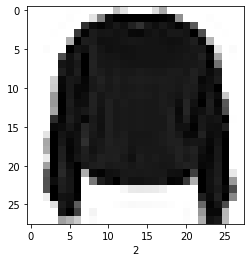

In [6]:
plt.imshow(x_train[7], cmap='binary')
plt.xlabel(y_train[7])
plt.show()

## Creating the Model

In [7]:
def create_model(hp): # To use keras tuner, pass hyperparameter object to model

  num_hidden_layers = 1
  num_units = 8
  dropout_rate = 0.1
  learning_rate = 0.01

  if hp:
    num_hidden_layers = hp.Choice('num_hidden_layers', values=[1, 2, 3])
    num_units = hp.Choice('num_units', values=[8, 16, 32])
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5)
    learning_rate = hp.Float('learning_rate', min_value=0.0001, max_value=0.01)

  model = tf.keras.models.Sequential()
  
  model.add(tf.keras.layers.Flatten(input_shape=(28, 28))) # Unroll 28 x 28 image to 784-D vectors
  model.add(tf.keras.layers.Lambda(lambda x: x/255.)) # Preprocessing step: normalize input

  for _ in range(0, num_hidden_layers):
    model.add(tf.keras.layers.Dense(num_units, activation='relu')) # Fully connected layer
    model.add(tf.keras.layers.Dropout(dropout_rate))
  
  model.add(tf.keras.layers.Dense(10, activation='softmax')) # Output layer, classification

  model.compile(
      loss='sparse_categorical_crossentropy', # Since labels are not one-hot encoded, categorical crossentropy is not used
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      metrics=['accuracy']
  )
  return model


In [8]:
create_model(None).summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
lambda (Lambda)              (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 8)                 6280      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                90        
Total params: 6,370
Trainable params: 6,370
Non-trainable params: 0
_________________________________________________________________


## Keras Tuner

In [9]:
class CustomTuner(kerastuner.tuners.BayesianOptimization):  # To find out optimal batch_size (in addition to the hp written in the create_model function)
  def run_trial(self, trial, *args, **kwargs): # Executes at the start of each trial, an experiment with certain hp values
    kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 32, 128, step=32)
    super(CustomTuner, self).run_trial(trial, *args, **kwargs) # Call the run_trial of the class that we're deriving this class from


In [10]:
# Create instance
tuner = CustomTuner(
    create_model,
    objective='val_accuracy',
    max_trials=20,
    directory='logs',
    project_name='fashion_mnist',
    overwrite=True
)

In [11]:
tuner.search_space_summary()

## Tuning Results

In [12]:
tuner.search(   # Similar to model.fit
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=5, verbose=False
)

INFO:tensorflow:Oracle triggered exit


In [13]:
tuner.results_summary(1)

In [14]:
model = tuner.get_best_models(num_models=1)[0]

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
lambda (Lambda)              (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


In [15]:
h = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=20, verbose=2,
    batch_size=128,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
    ]
)

Epoch 1/20
469/469 - 1s - loss: 0.4160 - accuracy: 0.8463 - val_loss: 0.4196 - val_accuracy: 0.8511
Epoch 2/20
469/469 - 1s - loss: 0.4154 - accuracy: 0.8461 - val_loss: 0.4204 - val_accuracy: 0.8488
Epoch 3/20
469/469 - 1s - loss: 0.4143 - accuracy: 0.8462 - val_loss: 0.4490 - val_accuracy: 0.8354
Epoch 4/20
469/469 - 1s - loss: 0.4100 - accuracy: 0.8499 - val_loss: 0.4243 - val_accuracy: 0.8477


In [16]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 0s 876us/step - loss: 0.4243 - accuracy: 0.8477


[0.4242979884147644, 0.8476999998092651]